---

_This notebook contains my summary from 'Applied Machine Learning in Python, University of Michigan'. 
[Jupyter Notebook FAQ](https://www.coursera.org/learn/python-machine-learning/resources/bANLa) course resource._

---
<a id="Top"></a>

# Setup

In [1]:
import os
os.chdir(r'C:\Users\csell\Documents\Knowledge\Data Science\dsref') #set working directory

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
cmap_bold = ListedColormap(['#FFFF00', '#00FF00', '#0000FF','#000000'])
sns.set(style='whitegrid')
%matplotlib notebook

import scipy.stats as sps

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import validation_curve, train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler

from dsref.utilities import plot_class_regions_for_classifier, plot_class_regions_for_classifier_subplot, plot_decision_tree, plot_feature_importances
 

# Datasets

In [5]:
from sklearn.datasets import make_classification, make_blobs
from sklearn.datasets import load_iris
from sklearn.datasets import load_breast_cancer
from dsref.utilities import load_crime_dataset

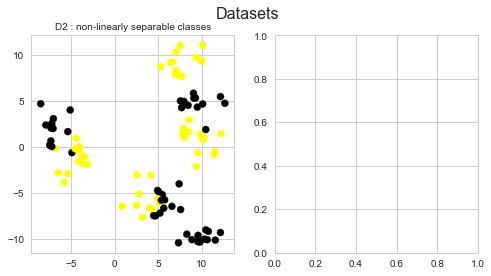

In [32]:
# Fruits
fruits = pd.read_table(os.path.join('data','fruit_data_with_colors.txt'))
iris = load_iris()

X_fruits_2d = fruits[['height', 'width']]
y_fruits_2d = fruits['fruit_label']

# Breast cancer dataset for classification
cancer = load_breast_cancer()
(X_cancer, y_cancer) = load_breast_cancer(return_X_y = True)

# Communities and Crime dataset
#(X_crime, y_crime) = load_crime_dataset()

# classes that are NOT LINEARLY SEPARABLE
# randomly generate 100 samples in 8 different clusters
X_D2, y_D2 = make_blobs(n_samples = 100, n_features = 2, centers = 8,
                       cluster_std = 1.3, random_state = 4)
y_D2 = y_D2 % 2 # changing the cluster label, number from 1 to 8, to a binary number

# mushroom dataset [UCI Mushroom Data Set](http://archive.ics.uci.edu/ml/datasets/Mushroom?ref=datanews.io) 
mushrooms = pd.read_csv(os.path.join('data','mushrooms.csv'))
mushrooms = pd.get_dummies(mushrooms).sample(frac=0.08)
X_m = mushrooms.iloc[:,2:]
y_m = mushrooms.iloc[:,1]


fig, subaxes = plt.subplots(1, 2, figsize=(8,4))
fig.suptitle('Datasets', fontsize=16)
subaxes[0].set_title('D2 : non-linearly separable classes', fontsize=10)
subaxes[0].scatter(X_D2[:,0], X_D2[:,1], c=y_D2, marker='o', s=50, cmap=cmap_bold)
plt.show()


In [35]:
y_m

3426    1
7603    1
3622    1
6023    1
5956    1
5243    0
1011    0
3828    0
1505    0
5727    0
7611    1
4865    1
1617    0
7007    1
757     0
7924    1
4316    1
7788    0
1630    1
8077    0
6609    1
6547    1
1302    0
6530    0
3796    1
4241    1
1103    1
5559    1
3570    1
5143    1
       ..
3282    1
4722    1
5067    1
1947    0
1038    0
6970    0
623     0
1859    0
6942    1
6046    1
5239    1
5278    1
4562    1
4189    1
8002    0
7073    0
8042    0
864     0
413     0
5992    1
1711    0
3265    1
3839    0
6722    1
6148    1
4168    1
2626    0
3481    0
403     0
7915    0
Name: class_p, Length: 650, dtype: uint8

# kNN Classifier

## Classifying Fruits  

The objective is to train a kNN classifier to identify fruits based on their mass, width, height and color.

### Loading the Data Set

In [5]:
print('Rows,Cols:',fruits.shape)
fruits.head(3)

Rows,Cols: (59, 7)


,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
0,1,apple,granny_smith,192,8.4,7.3,0.55
1,1,apple,granny_smith,180,8.0,6.8,0.59
2,1,apple,granny_smith,176,7.4,7.2,0.60


In [6]:
features = fruits.columns[3:7].tolist()
class_name = dict(zip(fruits.fruit_label.unique(),fruits.fruit_name.unique()))
print(f'features : {features}')
print(f'classes : {class_name}')

features : ['mass', 'width', 'height', 'color_score']
classes : {1: 'apple', 2: 'mandarin', 3: 'orange', 4: 'lemon'}


### Examining the data

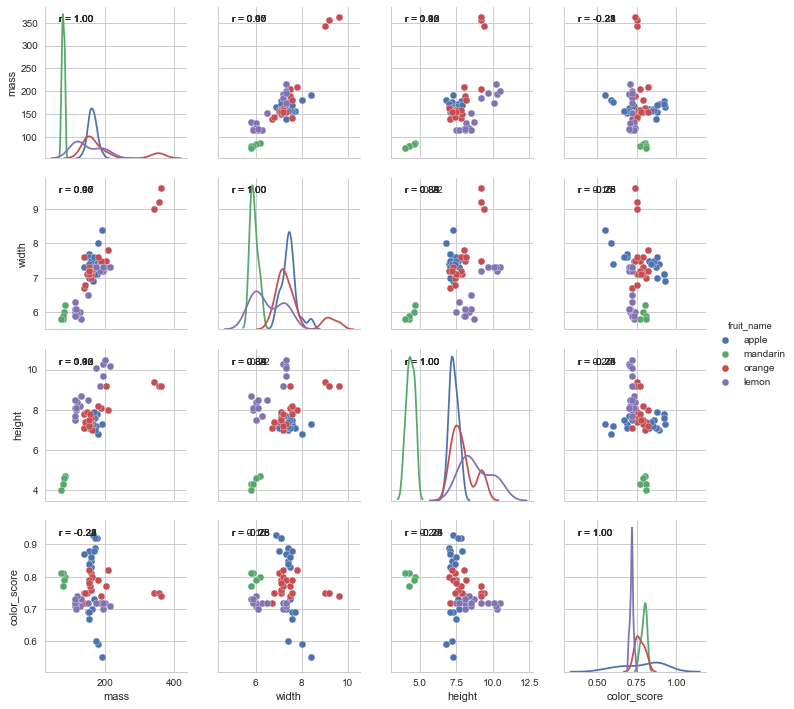

In [7]:
def corrfunc(x, y, **kws):
    (r, p) = sps.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r), xy=(.1, .9), xycoords=ax.transAxes)

fig = sns.pairplot(fruits[features + ['fruit_name']],hue='fruit_name',diag_kind='kde');
fig = fig.map(corrfunc)

<b>Comments</b> Mass <u>correlates</u> highly with width.  Mass and height are good for <u>segmentation</u>.

### Splitting the Data 

75% of the data will be used for **training** and 25% for **testing** the model.

In [8]:
X = fruits[features]
y = fruits['fruit_label']
# default is 75% / 25% train-test split
# If we want to keep the same split the value of 'random_state' should be kept the same
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0)
df_train = pd.concat([X_train, y_train],axis=1)


### Training the Classifier

In [9]:
# Try various options of n
for n in [1,3,5,11]:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train,y_train) #train the classifier
    print('For n={} -> Train Score: {:.2f} Test Score: {:.2f}'.format(n,knn.score(X_train, y_train),knn.score(X_test, y_test)))


For n=1 -> Train Score: 1.00 Test Score: 0.53
For n=3 -> Train Score: 0.82 Test Score: 0.60
For n=5 -> Train Score: 0.77 Test Score: 0.47
For n=11 -> Train Score: 0.59 Test Score: 0.40


### Classifying a new fruit 

With a kNN classifier (n=5) we will classify a fruit with the following characteristics:

- mass: 20g
- width: 4.3 cm
- height 5.5 cm 
- color scale: 0.92 


In [10]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train) #train the classifier

attributes = [[20,4.3,5.5,0.92]]

prediction = knn.predict(attributes) 

'The fruit is a ' + class_name[prediction[0]]

'The fruit is a mandarin'

# Kernelized Support Vector Machines

The basic idea of kernelized support vector machines is to apply what is called a kernel in order to, essentially, take the original data and transform it into a space that makes it easy to apply a linear classifier.  The kernel function must have some special propoerties.

<img src="../media/module2_svmkernel_5.png" alt="jupyter" style="width: 300px;"/>

But just as we did in the 1-dimensional case, we can map each 2-deminsional point ($x_0$,$x_1$) to a new 3-deminsional point by adding a third feature. Mathematically $1-(x_{0}^2 + x_{1}^2)$, and this transformation acts to shape the points into a parabaloid around (0,0). Now the wide points since they're close to (0,0), get mapped to points with higher vertical z values, that new third feature that are close to 1. While the black points which are farther from (0,0) get mapped to points with z values that either close to 0 or even negative. 

<img src="../media/module2_svmkernel_5.3.png" alt="jupyter" style="width: 300px;"/>

Here is another very [Nice example](https://www.youtube.com/watch?v=ikt7Qze0czE) And this video at minute 6 shows [the common types of kernels](https://www.youtube.com/watch?v=OmTu0fqUsQk).

Next is a comparison of two kernels using python.

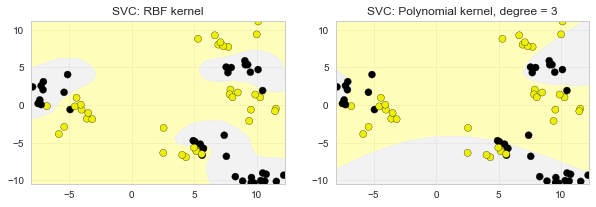

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state = 0)
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

# The default SVC kernel is radial basis function (RBF)
clf = SVC().fit(X_train, y_train)
plot_class_regions_for_classifier_subplot(clf,X_train, y_train, None, None, 'SVC: RBF kernel',ax[0])
clf = SVC(kernel = 'poly', degree = 3)  # polynomial kernel
plot_class_regions_for_classifier_subplot(clf.fit(X_train, y_train), X_train, y_train, None, None,'SVC: Polynomial kernel, degree = 3',ax[1])

## Impact of gamma in RBK 
#### $K(x,x') = \exp[-\gamma \cdot \lvert \lvert x-x' \lvert \lvert^2]$

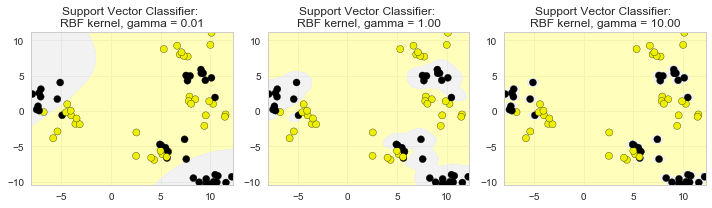

In [12]:
fig, subaxes = plt.subplots(1, 3, figsize=(10, 3))
for this_gamma, subplot in zip([0.01, 1.0, 10.0], subaxes):
    clf = SVC(kernel = 'rbf', gamma=this_gamma).fit(X_train, y_train)
    title = f'Support Vector Classifier: \nRBF kernel, gamma = {this_gamma:.2f}'    
    plot_class_regions_for_classifier_subplot(clf, X_train, y_train, None, None, title, subplot)
    plt.tight_layout()

## Support Vector Machine with RBF kernel: using both C and gamma parameter 

If $\gamma$ is large, then C will have little to no effect. Well, if $\gamma$ is small, the model is much more constrained and the effective C will be similar to how it would affect a linear classifier. 

Typically, $\gamma$ and C are tuned together, with the optimal combination typically in an intermediate range of values. For example, $\gamma$ between 0.0001 and 10 and C between 0.1 and 100. Though the specifical optimal values will depend on your application. 

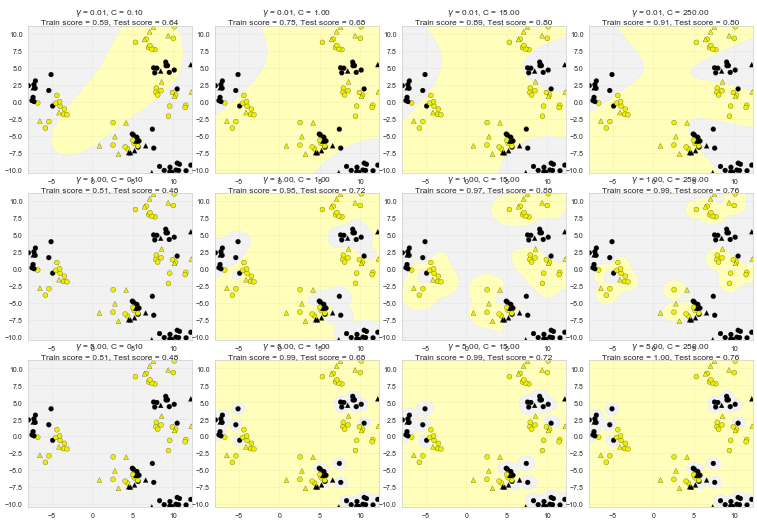

In [13]:
fig, subaxes = plt.subplots(3, 4, figsize=(15, 10), dpi=50)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

for this_gamma, this_axis in zip([0.01, 1, 5], subaxes):
    for this_C, subplot in zip([0.1, 1, 15, 250], this_axis):
        title = f'$\gamma$ = {this_gamma:.2f}, C = {this_C:.2f}'
        clf = SVC(kernel = 'rbf', gamma = this_gamma, C = this_C).fit(X_train, y_train)
        plot_class_regions_for_classifier_subplot(clf, X_train, y_train, X_test, y_test, title, subplot)


## Application of SVMs to a real dataset: unnormalized data

Kernelized SVMs are pretty sensitive to settings of gamma. The most important thing to remember **when applying SVMs is that it's important to normalize the input data, so that all the features have comparable units that are on the same scale**.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, random_state = 0)

clf = SVC(C=10).fit(X_train, y_train)
print('Breast cancer dataset (unnormalized features)')
print(f'Accuracy of RBF-kernel SVC on training set: {clf.score(X_train, y_train):.2f}')
print(f'Accuracy of RBF-kernel SVC on test set: {clf.score(X_test, y_test):.2f}')

scaler = MinMaxScaler()
scaler.fit(X_train)  # to get the scale to normalize the data
X_train_scaled = scaler.transform(X_train)  # actually normalize the data
X_test_scaled = scaler.transform(X_test)

clf = SVC(C=10).fit(X_train_scaled, y_train)
print('Breast cancer dataset (normalized with MinMax scaling)')
print(f'RBF-kernel SVC (with MinMax scaling) training set accuracy: {clf.score(X_train_scaled, y_train):.2f}')
print(f'RBF-kernel SVC (with MinMax scaling) test set accuracy: {clf.score(X_test_scaled, y_test):.2f}')

Breast cancer dataset (unnormalized features)
Accuracy of RBF-kernel SVC on training set: 1.00
Accuracy of RBF-kernel SVC on test set: 0.63
Breast cancer dataset (normalized with MinMax scaling)
RBF-kernel SVC (with MinMax scaling) training set accuracy: 0.98
RBF-kernel SVC (with MinMax scaling) test set accuracy: 0.96


<img src="..\media\module2_svmkernel_14.png" alt="jupyter" style="width: 400px;"/>

<a id="CrossValidation"></a>
# Cross Validation
[<<](#Top)

Cross validation, is a method that goes beyond evaluating a single model using a single train/test split of the data, by using multiple train/test splits each of which is used to train and evaluate a separate model. 

It basically  gives more stable and reliable estimates of how the classifier is likely to perform on average, by running multiple different training splits and averaging the results, instead of relaying entirely in a single training set.

<img src="../media/module2_crossvalidation_1.png" alt="jupyter" style="width: 400px;"/>

In [15]:
clf = KNeighborsClassifier(n_neighbors = 5)
X = X_fruits_2d.as_matrix()
y = y_fruits_2d.as_matrix()
cv_scores = cross_val_score(clf, X, y)

print('Cross-validation scores (3-fold):', cv_scores)
print(f'Mean cross-validation score (3-fold): {np.mean(cv_scores):.3f}')


Cross-validation scores (3-fold): [ 0.77272727  0.73684211  0.77777778]
Mean cross-validation score (3-fold): 0.762


## A note on performing cross-validation for more advanced scenarios.

In some cases (e.g. when feature values have very different ranges), we've seen the need to scale or normalize the training and test sets before use with a classifier. The proper way to do cross-validation when you need to scale the data is *not* to scale the entire dataset with a single transform, since this will indirectly leak information into the training data about the whole dataset, including the test data (see the lecture on data leakage later in the course).  Instead, **scaling/normalizing must be computed and applied for each cross-validation fold separately**.  To do this, the easiest way in scikit-learn is to use *pipelines*.  While these are beyond the scope of this course, further information is available in the scikit-learn documentation here:

http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

or the Pipeline section in the recommended textbook: Introduction to Machine Learning with Python by Andreas C. Müller and Sarah Guido (O'Reilly Media). It is in the section Algorithm Chains and Pipelines page 305.

In [16]:
# Gamma values : array([  1.00e-03,   1.00e-01,   1.00e+01,   1.00e+03])
param_range = np.logspace(-3, 3, 4)
train_scores, test_scores = validation_curve(SVC(), X, y, param_name='gamma', param_range=param_range, cv=3)
print(train_scores)
print(test_scores)
param_range

[[ 0.48648649  0.425       0.41463415]
 [ 0.83783784  0.725       0.75609756]
 [ 0.91891892  0.9         0.90243902]
 [ 1.          1.          0.97560976]]
[[ 0.45454545  0.31578947  0.33333333]
 [ 0.81818182  0.68421053  0.66666667]
 [ 0.40909091  0.78947368  0.66666667]
 [ 0.36363636  0.21052632  0.33333333]]


array([  1.00000000e-03,   1.00000000e-01,   1.00000000e+01,
         1.00000000e+03])

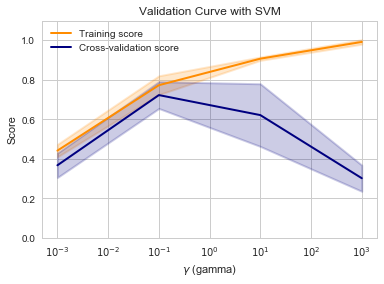

In [17]:
plt.figure()

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title('Validation Curve with SVM')
plt.xlabel('$\gamma$ (gamma)')
plt.ylabel('Score')
plt.ylim(0.0, 1.1)
lw = 2

plt.semilogx(param_range, train_scores_mean, label='Training score', color='darkorange', lw=lw)
plt.fill_between(param_range, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std, alpha=0.2, color='darkorange', lw=lw)
plt.semilogx(param_range, test_scores_mean, label='Cross-validation score', color='navy', lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color='navy', lw=lw)

plt.legend(loc='best')
plt.show()

# Decision Trees

This a popular supervise learning method that can be used for classification and regression. They are easy to use and understand and are often a good exploratory method if you are interested in getting a better idea about what the influencial features are in your data set. **Decision Trees learns a series of explicit If Then rules on features values that results in the descition that predicts the target value**. 
We can form these questions into a tree with **node respresenting one question** and the **yes/not possible answears** as the left and right **branches from  that node**. That connect the node to the next level of the tree. One question being answered at each level. **At the bottom of tree are nodes called "leaf nodes" that repressent actual objects as the possible answers**.

One strategy to prevent the tree to becoming really detailed and complex is to stop its growth early, this is called **Prepruning**. Another strategy is to build a complete tree by pure leaves but then prune back the tree to a simpler form, it is called **postprunning or prunning**. In **sklern it is implemented just preprunning**. 


Accuracy of Decision Tree classifier on training set: 0.99
Accuracy of Decision Tree classifier on test set: 0.97


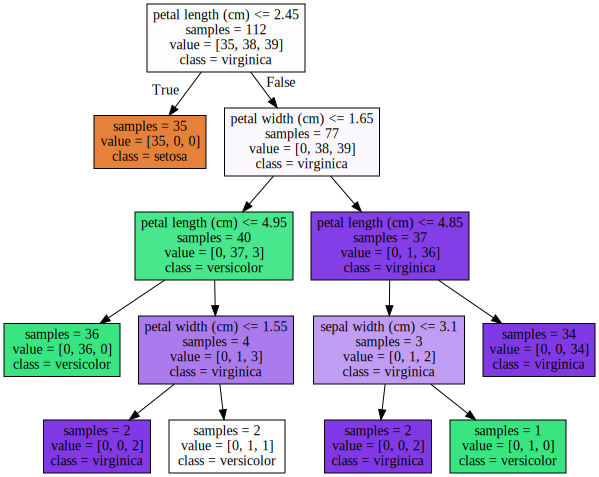

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, random_state=3)

clf = DecisionTreeClassifier(max_depth=4).fit(X_train, y_train)

print(f'Accuracy of Decision Tree classifier on training set: {clf.score(X_train, y_train):.2f}')
print(f'Accuracy of Decision Tree classifier on test set: {clf.score(X_test, y_test):.2f}')

plot_decision_tree(clf, iris.feature_names, iris.target_names)

## Feature importance

**Another way of analysing the tree, is to do the feature importance calculations**. It is one of the most useful and widly used types of summary analisys that you can perform in a supervise leaning model. The feature inportance is between 0 and 1, and it tell you how important that feature is for the overall prediction accuracy.

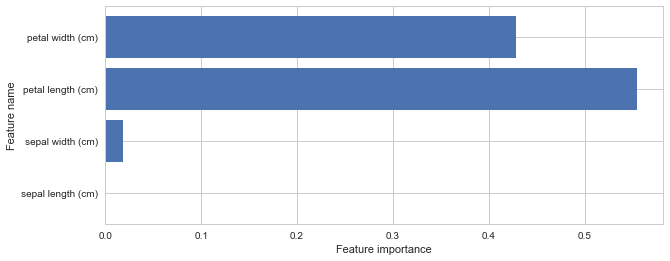

In [8]:
plt.figure(figsize=(10,4))
plot_feature_importances(clf, iris.feature_names)

## CASE : Breast Cancer

Accuracy of Decision Tree classifier on training set: 0.96
Accuracy of Decision Tree classifier on test set: 0.94


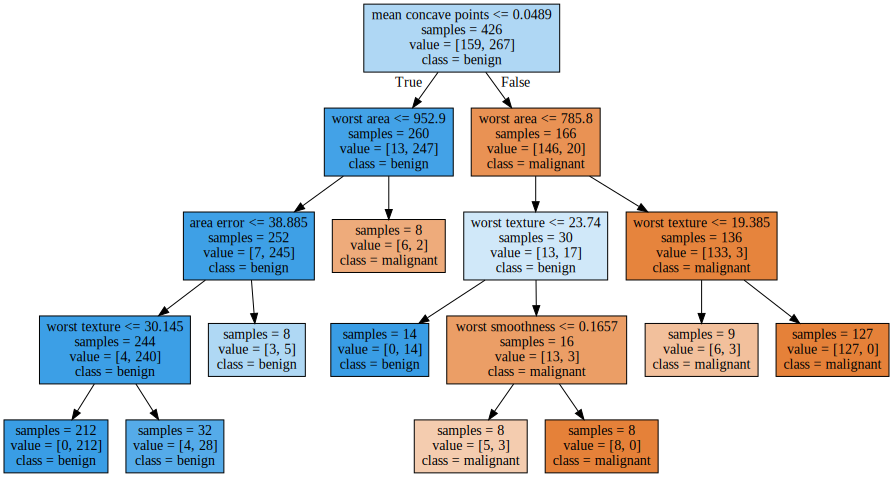

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, random_state=0)

clf = DecisionTreeClassifier(max_depth=4, min_samples_leaf=8, random_state=0).fit(X_train, y_train)
print(f'Accuracy of Decision Tree classifier on training set: {clf.score(X_train, y_train):.2f}')
print(f'Accuracy of Decision Tree classifier on test set: {clf.score(X_test, y_test):.2f}')
plot_decision_tree(clf, cancer.feature_names, cancer.target_names)

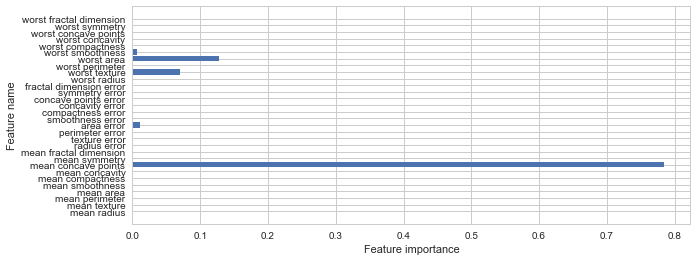

In [16]:
plt.figure(figsize=(10,4))
plot_feature_importances(clf, cancer.feature_names)

## Summary

<img src="../media/module2_trees_13.png" alt="jupyter" style="width: 500px;"/>


<img src="../media/module2_trees_14.png" alt="jupyter" style="width: 500px;"/>

# Bibliography

Domings, Pedro. [A Few Useful Things to Know about Machine Learning](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)